In [18]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from evaluation import get_results, get_cross_validation_scores, save_results_to_csv, plot_parameter_sensitivity
from scipy.stats import loguniform
import pandas as pd
import matplotlib.pylab as plt
from sklearn.metrics import classification_report
import time
import numpy as np
from preprocess import Preprocessing

In [19]:
pp = Preprocessing()
X_train, X_test, y_train, y_test = pp.load_preprocessed_speeddating(drop_ambitious=False)

In [20]:
# df to save random search times
index_name = 'model_name'
column_name = 'randsearch_time'

df_times = pd.DataFrame(
    index = pd.Index([], name=index_name),
    columns = [column_name],
    dtype = np.float64
)

              precision    recall  f1-score   support

   False (0)       0.95      0.73      0.83      1071
    True (1)       0.39      0.82      0.53       223

    accuracy                           0.75      1294
   macro avg       0.67      0.78      0.68      1294
weighted avg       0.85      0.75      0.77      1294



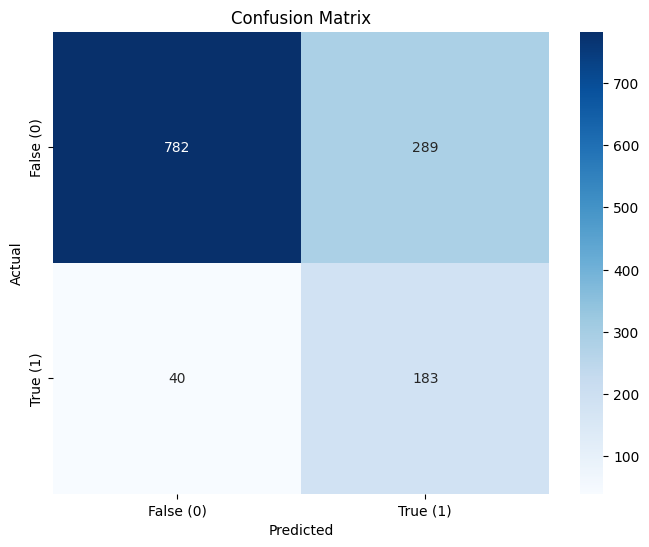

In [21]:
target_names = ['False (0)', 'True (1)']

ridge_model = RidgeClassifier(class_weight= 'balanced',random_state=42)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)

get_results(y_test, y_pred_ridge, target_names)

In [22]:
get_cross_validation_scores(ridge_model, X_train, y_train )

10-Fold CV Scores: [0.80054196 0.74385086 0.78793763 0.76824489 0.78473594 0.76910626
 0.75175577 0.78467057 0.75029369 0.7726628 ]
Average f1_weighted Score: 0.7714
Standard Deviation: 0.0176


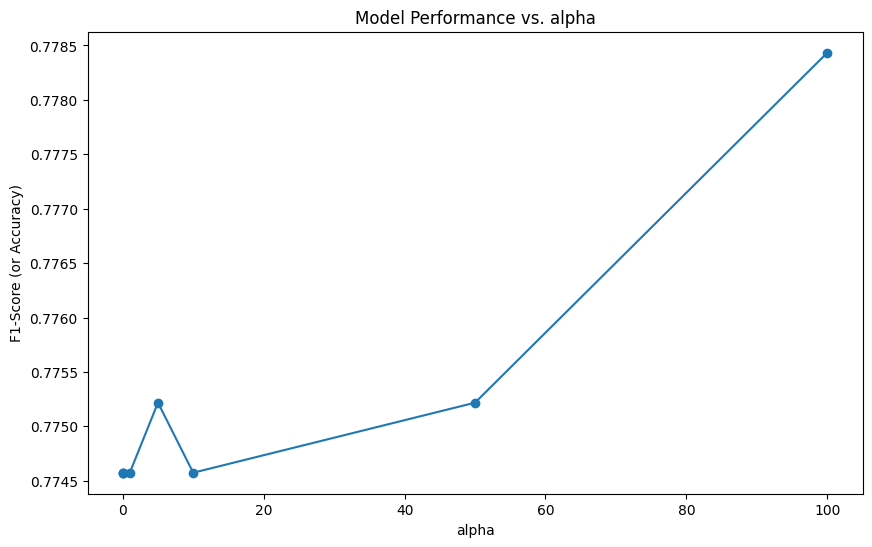

Alpha Values Tested: [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
Weighted F1 Scores: ['0.7746', '0.7746', '0.7746', '0.7746', '0.7752', '0.7746', '0.7752', '0.7784']


In [23]:
f1_scores_ridge = []
param_range = [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
# 2. Iterate through the alpha values
for alpha_val in param_range:
    # Instantiate the RidgeClassifier with the current alpha
    ridge_exp = RidgeClassifier(
        alpha=alpha_val,  # Set the current alpha value
        class_weight='balanced',
        random_state=42
    )
    
    # Train the model
    ridge_exp.fit(X_train, y_train)
    
    # Generate the classification report
    report = classification_report(
        y_test, 
        ridge_exp.predict(X_test), 
        output_dict=True
    )
    
    # Store the weighted F1-score
    f1_scores_ridge.append(report['weighted avg']['f1-score'])

# 3. Plot the results
# The plotting logic is simpler for Ridge as there's no 'None' value
plot_parameter_sensitivity(
    param_values=param_range, 
    scores=f1_scores_ridge, 
    param_name="alpha"
)

# Optional: Print results
print("Alpha Values Tested:", param_range)
print("Weighted F1 Scores:", [f"{score:.4f}" for score in f1_scores_ridge])

In [24]:
model_name = 'ridge_weights'

# Parameters to optimize
param_distributions = {
    'alpha': loguniform(1e-3, 1),
}


random_search = RandomizedSearchCV(
    estimator=ridge_model,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,     
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

df_times.loc[model_name, column_name] = training_time
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1-score: {random_search.best_score_:.4f}")

final_model = random_search.best_estimator_

Best parameters found: {'alpha': np.float64(0.5345166110646817)}
Best F1-score: 0.7683


              precision    recall  f1-score   support

   False (0)       0.95      0.73      0.83      1071
    True (1)       0.39      0.82      0.53       223

    accuracy                           0.75      1294
   macro avg       0.67      0.78      0.68      1294
weighted avg       0.85      0.75      0.77      1294



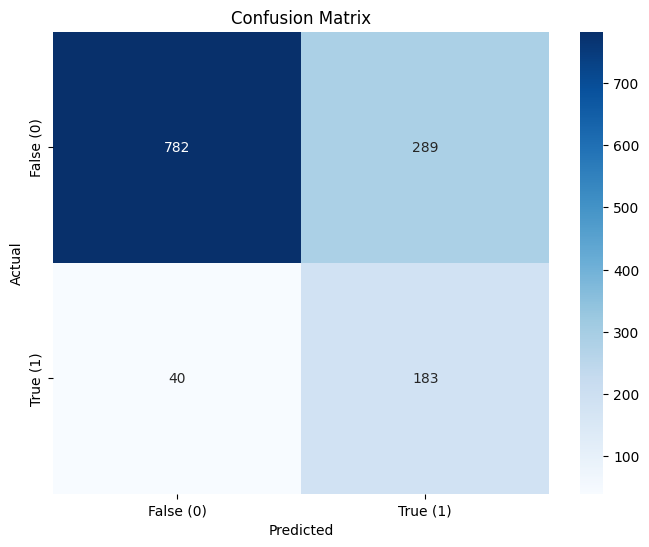

In [25]:
y_pred_ridge_opt = final_model.predict(X_test)
get_results(y_test, y_pred_ridge_opt, target_names)

## Without balanced weights

              precision    recall  f1-score   support

   False (0)       0.85      0.98      0.91      1071
    True (1)       0.65      0.14      0.23       223

    accuracy                           0.84      1294
   macro avg       0.75      0.56      0.57      1294
weighted avg       0.81      0.84      0.79      1294



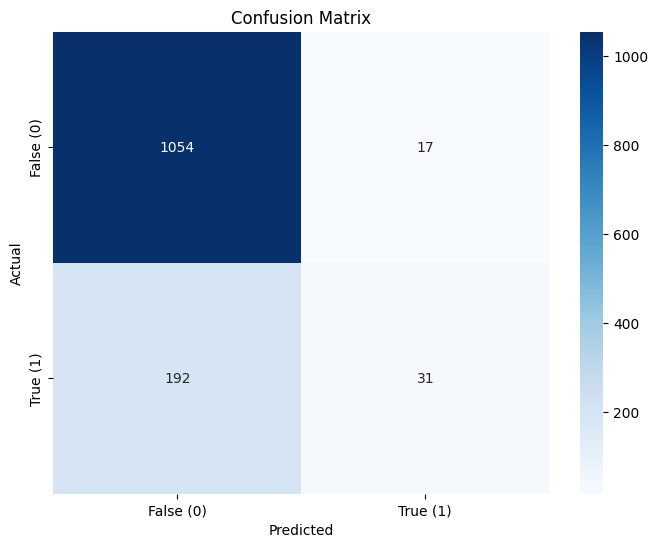

In [26]:
ridge_model_noweights = RidgeClassifier(random_state=42)
ridge_model_noweights.fit(X_train, y_train)

y_pred_ridge = ridge_model_noweights.predict(X_test)

get_results(y_test, y_pred_ridge, target_names)

In [27]:
get_cross_validation_scores(ridge_model_noweights, X_train, y_train )

10-Fold CV Scores: [0.80182735 0.78150195 0.78489747 0.78618437 0.79367887 0.78618437
 0.78361852 0.78361443 0.79007003 0.80422628]
Average f1_weighted Score: 0.7896
Standard Deviation: 0.0075


In [28]:
model_name = 'ridge_noweights'

# Parameters to optimize
param_distributions = {
    'alpha': loguniform(1e-3, 1),
}


random_search = RandomizedSearchCV(
    estimator=ridge_model_noweights,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,     
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
df_times.loc[model_name, column_name] = training_time

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1-score: {random_search.best_score_:.4f}")

final_model = random_search.best_estimator_

Best parameters found: {'alpha': np.float64(0.013292918943162165)}
Best F1-score: 0.7892


              precision    recall  f1-score   support

   False (0)       0.85      0.98      0.91      1071
    True (1)       0.65      0.14      0.23       223

    accuracy                           0.84      1294
   macro avg       0.75      0.56      0.57      1294
weighted avg       0.81      0.84      0.79      1294



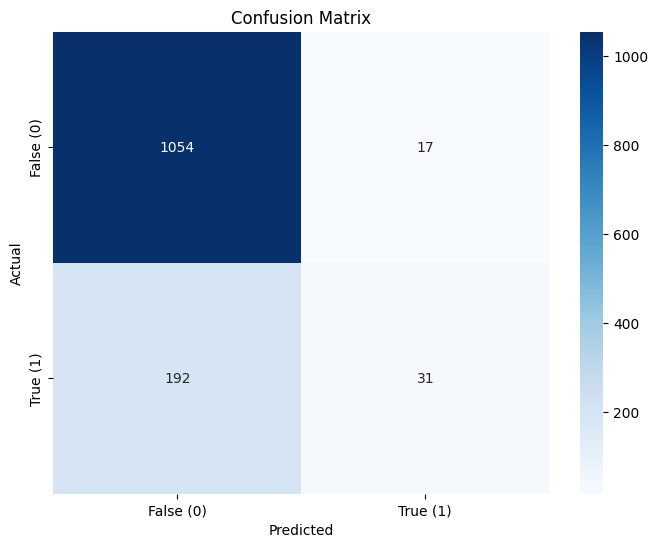

In [29]:
y_pred_ridge_opt = final_model.predict(X_test)
get_results(y_test, y_pred_ridge_opt, target_names)

## No scaling

              precision    recall  f1-score   support

   False (0)       0.95      0.73      0.83      1071
    True (1)       0.39      0.82      0.53       223

    accuracy                           0.75      1294
   macro avg       0.67      0.78      0.68      1294
weighted avg       0.85      0.75      0.77      1294



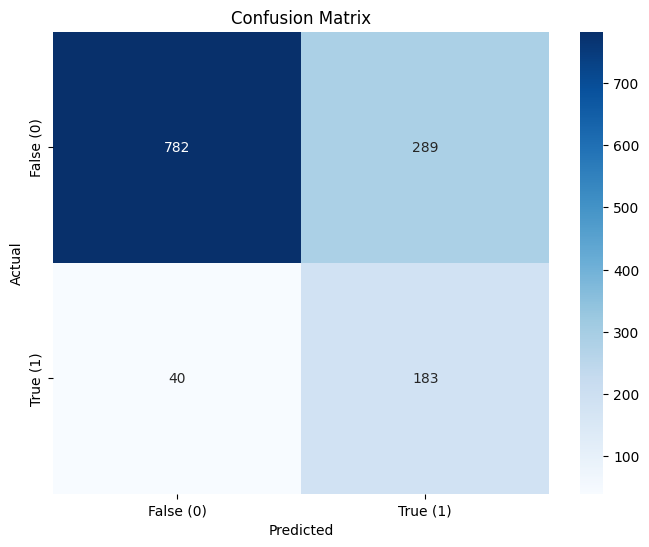

In [31]:
pp = Preprocessing()
X_train, X_test, y_train, y_test = pp.load_preprocessed_speeddating(drop_ambitious=False)
target_names = ['False (0)', 'True (1)']
ridge_model = RidgeClassifier(class_weight='balanced',random_state=42)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)

get_results(y_test, y_pred_ridge, target_names)

In [32]:
model_name = 'ridge_unscaled'

# Parameters to optimize
param_distributions = {
    'alpha': loguniform(1e-3, 1),
}


random_search = RandomizedSearchCV(
    estimator=ridge_model,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,     
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
df_times.loc[model_name, column_name] = training_time

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1-score: {random_search.best_score_:.4f}")

final_model = random_search.best_estimator_

Best parameters found: {'alpha': np.float64(0.5345166110646817)}
Best F1-score: 0.7683


              precision    recall  f1-score   support

   False (0)       0.95      0.73      0.83      1071
    True (1)       0.39      0.82      0.53       223

    accuracy                           0.75      1294
   macro avg       0.67      0.78      0.68      1294
weighted avg       0.85      0.75      0.77      1294



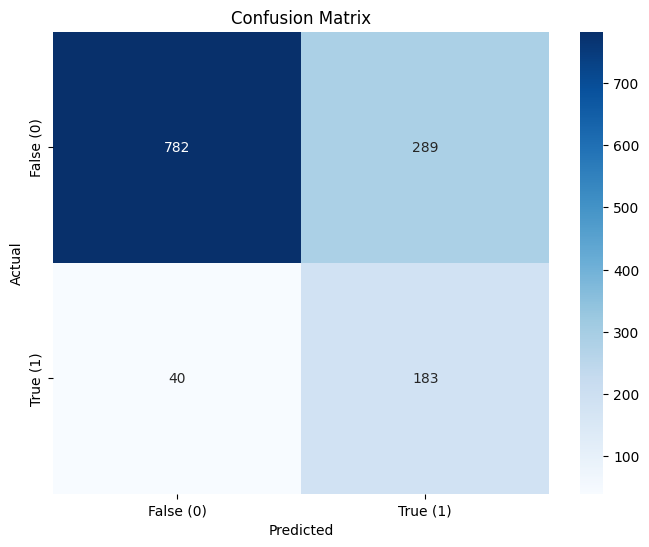

In [33]:
y_pred_ridge_opt = final_model.predict(X_test)
get_results(y_test, y_pred_ridge_opt, target_names)